Pytoch의 dataLoader에 Sampling 기능을 추가한 버전(25.07.28)

## 0. Configurations

In [1]:
# ====================================================================
# Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함
import os  # 디렉토리, 파일 경로 조작 등

import torch
import os
import numpy as np

from pathlib import Path  # payhon path
import matplotlib.pyplot as plt

import albumentations as A
import cv2  # OpenCV - 고급 이미지/비디오 처리
import torch
from torch.utils.data import Dataset  # 커스텀 데이터셋, 배치 로딩
import pandas as pd
import os
import json
from tqdm import tqdm
from pathlib import Path

# Garbage Collector 모듈
import gc

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import box_iou  # 맨 위에 import 추가


# 메모리 정리 루틴
gc.collect()
torch.cuda.empty_cache()


# --- 디바이스 설정 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

# --- 학습 하이퍼파라미터 ---
BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 1e-5
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# --- 데이터 경로 설정 ---
# DATA_ROOT = path
# DATA_ROOT = "data/raw/ai03-level1-project/"  # 경로
# TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "train_images")
# TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, "train_annotations")
# TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test_images")
# PROCESSED_TRAIN_CSV = "../data/processed/train_df.csv"  # 데이터 전처리된 csv 파일

# --- 모델 설정 ---
NUM_CLASSES = 73
MODEL_NAME = "BASELINE_fasterrcnn_Mobilev3_WeightedSampler"
USE_PRETRAINED = True

# --- 학습 고도화 설정 ---
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# --- 실험 로깅용 설정 ---
USE_WANDB = True
WANDB_PROJECT = "AI03-Project-1"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"


# --- 실험 결과 저장 경로 ---
EXPERIMENT_DIR = "../experiments"

## 1. Data-preprocessing

In [2]:
def parse_raw_annotations(ann_dir: Path) -> pd.DataFrame:
    """
    복잡한 3중 폴더 구조의 원본 어노테이션을 파싱하여
    하나의 Pandas DataFrame으로 반환하는 함수.
    """
    all_annotations = []

    # Level 1: 이미지별 폴더 순회
    image_level_dirs = os.listdir(ann_dir)
    for image_dir_name in tqdm(image_level_dirs, desc="[L1] Images"):
        image_dir_path = ann_dir / image_dir_name
        if not image_dir_path.is_dir():
            continue

        # Level 2: 알약 종류 폴더 순회
        pill_level_dirs = os.listdir(image_dir_path)
        for pill_dir_name in pill_level_dirs:
            pill_dir_path = image_dir_path / pill_dir_name
            if not pill_dir_path.is_dir():
                continue

            # Level 3: 실제 .json 파일 파싱
            json_files = [f for f in os.listdir(pill_dir_path) if f.endswith(".json")]
            if not json_files:
                continue

            # 첫 번째 json 파일만 사용
            json_file_path = pill_dir_path / json_files[0]

            try:
                with open(json_file_path, "r", encoding="utf-8") as f:
                    ann_data = json.load(f)

                    image_info = ann_data.get("images", [{}])[0]
                    annotation_info = ann_data.get("annotations", [{}])[0]
                    category_info = ann_data.get("categories", [{}])[0]

                    all_annotations.append(
                        {
                            "image_id": image_info.get("id"),
                            "file_name": image_info.get("file_name"),
                            "width": image_info.get("width"),
                            "height": image_info.get("height"),
                            "category_id": category_info.get("id"),
                            "class_name": category_info.get("name"),
                            "bbox": annotation_info.get("bbox"),
                        }
                    )
            except Exception as e:
                print(f"\n파일 처리 에러: {json_file_path}, 에러: {e}")

    return pd.DataFrame(all_annotations)

In [3]:
# 1. 핵심 함수를 호출해서 DataFrame 생성
from pathlib import Path

BASE_DIR = Path("../")  # 상대경로
RAW_DATA_DIR = BASE_DIR / "data/raw/ai03-level1-project"
PROCESSED_DATA_DIR = BASE_DIR / "data/processed"

TRAIN_IMAGE_DIR = RAW_DATA_DIR / "train_images"
TRAIN_ANNO_DIR = RAW_DATA_DIR / "train_annotations"
TEST_IMAGE_DIR = RAW_DATA_DIR / "test_images"
SAVE_PATH = PROCESSED_DATA_DIR / "train_df.csv"
train_df = parse_raw_annotations(TRAIN_ANNO_DIR)

# --- (1). bbox 컬럼을 4개로 분리 ---
# bbox 컬럼 분리
bbox_df = pd.DataFrame(
    train_df["bbox"].tolist(), columns=["bbox_x", "bbox_y", "bbox_w", "bbox_h"]
)
train_df = pd.concat([train_df.drop("bbox", axis=1), bbox_df], axis=1)

# ✨ --- [핵심 수정] 잘못된 바운딩 박스 데이터 제거 ---
# xmax (bbox_x + bbox_w)가 이미지 너비(width)를 초과하는 경우
invalid_x = train_df["bbox_x"] + train_df["bbox_w"] > train_df["width"]
# ymax (bbox_y + bbox_h)가 이미지 높이(height)를 초과하는 경우
invalid_y = train_df["bbox_y"] + train_df["bbox_h"] > train_df["height"]

# 잘못된 데이터를 필터링
invalid_rows = train_df[invalid_x | invalid_y]
if not invalid_rows.empty:
    print(f"--- {len(invalid_rows)}개의 잘못된 바운딩 박스 데이터를 찾았습니다. ---")
    print(
        invalid_rows[
            ["file_name", "width", "height", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]
        ]
    )

    # 유효한 데이터만 남김
    train_df = train_df[~(invalid_x | invalid_y)]
    print(f"\n잘못된 데이터를 제거하고, {len(train_df)}개의 데이터만 사용합니다.")

# --- (2). category_id를 새로운 label_idx로 매핑 ---
# 고유한 category_id 목록을 뽑아 정렬
unique_category_ids = sorted(train_df["category_id"].unique())
NUM_CLASSES = len(unique_category_ids)
# category_id를 0, 1, 2... 인덱스로 변환하는 딕셔너리 생성
id_to_idx = {
    int(original_id): idx
    for idx, original_id in enumerate(
        unique_category_ids, start=1
    )  # <--- start=1 추가!
}
# 이 매핑 정보를 사용해서 'label_idx'라는 새 컬럼을 추가
train_df["label_idx"] = train_df["category_id"].map(id_to_idx)

# processed 폴더 존재 여부 체크
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# 나중에 추론 결과에서 원래 클래스 이름을 찾을 수 있도록 매핑 정보도 저장
label_map = {
    "id_to_idx": id_to_idx,
    "idx_to_id": {idx: int(original_id) for original_id, idx in id_to_idx.items()},
    "id_to_name": dict(zip(train_df["category_id"], train_df["class_name"])),
}
with open(PROCESSED_DATA_DIR / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)

print(f"\n총 {len(unique_category_ids)}개의 고유 클래스를 발견했습니다.")
print("라벨 매핑 정보를 'data/processed/label_map.json'에 저장했습니다.")


# 3. 최종 DataFrame을 CSV 파일로 저장
train_df.to_csv(SAVE_PATH, index=False)

print(f"\n--- 데이터 전처리 및 저장 완료! ---")
print(train_df.head())

[L1] Images:   0%|          | 0/498 [00:00<?, ?it/s]

[L1] Images: 100%|██████████| 498/498 [00:01<00:00, 269.85it/s]



총 73개의 고유 클래스를 발견했습니다.
라벨 매핑 정보를 'data/processed/label_map.json'에 저장했습니다.

--- 데이터 전처리 및 저장 완료! ---
   image_id                                          file_name  width  height  \
0       895  K-003544-010221-016551-021026_0_2_0_2_75_000_2...    976    1280   
1       896  K-003544-010221-016551-021026_0_2_0_2_90_000_2...    976    1280   
2       895  K-003544-010221-016551-021026_0_2_0_2_75_000_2...    976    1280   
3       895  K-003544-010221-016551-021026_0_2_0_2_75_000_2...    976    1280   
4      1310  K-003483-027733-028763-029667_0_2_0_2_90_000_2...    976    1280   

   category_id         class_name  bbox_x  bbox_y  bbox_w  bbox_h  label_idx  
0        10220         쎄로켈정 100mg     584     774     227     223         14  
1         3543  무코스타정(레바미피드)(비매품)     110     234     207     200          5  
2        21025       펠루비정(펠루비프로펜)     101     821     178     180         36  
3        16550      동아가바펜틴정 800mg     534      42     296     458         24  
4        28762   

<Axes: xlabel='label_idx'>

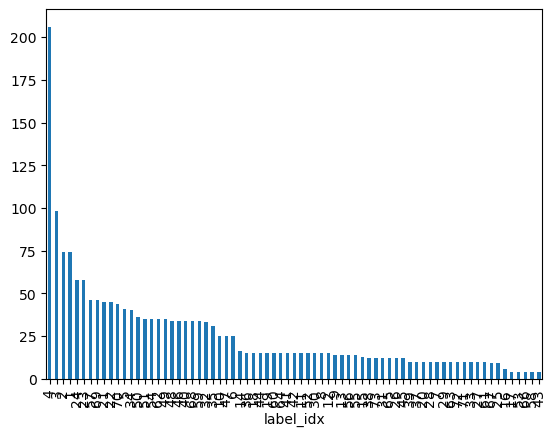

In [4]:
train_df["label_idx"].value_counts().plot(kind="bar")

In [5]:
train_df["class_name"].value_counts()

class_name
기넥신에프정(은행엽엑스)(수출용)    206
일양하이트린정 2mg            98
뮤테란캡슐 100mg            74
보령부스파정 5mg             74
동아가바펜틴정 800mg          58
                     ... 
자이프렉사정 2.5mg            4
졸로푸트정 100mg             4
브린텔릭스정 20mg             4
렉사프로정 15mg              4
쿠에타핀정 25mg              4
Name: count, Length: 73, dtype: int64

In [6]:
classes_tmp = train_df["class_name"].unique()
classes_tmp

array(['쎄로켈정 100mg', '무코스타정(레바미피드)(비매품)', '펠루비정(펠루비프로펜)', '동아가바펜틴정 800mg',
       '트라젠타정(리나글립틴)', '기넥신에프정(은행엽엑스)(수출용)', '트윈스타정 40/5mg', '리바로정 4mg',
       '자누메트엑스알서방정 100/1000mg', '플라빅스정 75mg', '리렉스펜정 300mg/PTP',
       '큐시드정 31.5mg/PTP', '비타비백정 100mg/병', '아모잘탄정 5/100mg', '자누비아정 50mg',
       '리피토정 20mg', '아토젯정 10/40mg', '가바토파정 100mg', '레일라정', '세비카정 10/40mg',
       '로수젯정10/5밀리그램', '크레스토정 20mg', '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0',
       '일양하이트린정 2mg', '타이레놀정500mg', '뮤테란캡슐 100mg', '트루비타정 60mg/병', '알드린정',
       '에빅사정(메만틴염산염)(비매품)', '아토르바정 10mg', '카나브정 60mg', '자누메트정 50/850mg',
       '노바스크정 5mg', '트라젠타듀오정 2.5/850mg', '제미메트서방정 50/1000mg',
       '비모보정 500/20mg', '라비에트정 20mg', '보령부스파정 5mg', '다보타민큐정 10mg/병',
       '써스펜8시간이알서방정 650mg', '리피로우정 20mg', '글리아타민연질캡슐', '카발린캡슐 25mg',
       '엑스포지정 5/160mg', '케이캡정 50mg', '놀텍정 10mg',
       '타이레놀이알서방정(아세트아미노펜)(수출용)', '조인스정 200mg', '자이프렉사정 2.5mg',
       '콜리네이트연질캡슐 400mg', '울트라셋이알서방정', '에스원엠프정 20mg', '메가파워정 90mg/병',
       '맥시부펜이알정 300mg', '삼남건조수산화알루미늄겔정',

In [7]:
# 1. 'category_id'와 'class_name' 컬럼으로 고유한 쌍을 찾고, ID 기준으로 정렬
class_mapping_df = (
    train_df[["category_id", "class_name"]]
    .drop_duplicates()
    .sort_values(by="category_id")
)
# 2. 정렬된 DataFrame에서 클래스 이름만 리스트로 추출
sorted_class_names = [
    name.split("(")[0].strip() for name in class_mapping_df["class_name"]
]
# 3. 맨 앞에 'background' 추가
classes = ["background"] + sorted_class_names

print(f"총 클래스 개수 (배경 포함): {len(classes)}")
print(f"클래스 리스트: {classes}")

총 클래스 개수 (배경 포함): 74
클래스 리스트: ['background', '보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정', '무코스타정', '알드린정', '뉴로메드정', '타이레놀정500mg', '에어탈정', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.5mg/PTP', '아모잘탄정 5/100mg', '세비카정 10/40mg', '트윈스타정 40/5mg', '카나브정 60mg', '울트라셋이알서방정', '졸로푸트정 100mg', '트라젠타정', '비모보정 500/20mg', '레일라정', '리바로정 4mg', '렉사프로정 15mg', '트라젠타듀오정 2.5/850mg', '낙소졸정 500/20mg', '아질렉트정', '자누메트엑스알서방정 100/1000mg', '글리아타민연질캡슐', '신바로정', '에스원엠프정 20mg', '브린텔릭스정 20mg', '글리틴정', '제

## 2. Load a model

In [8]:
# (1) 데이터 증강 (Augmentation) : Albumentations 라이브러리 사용
train_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # PyTorch 텐서로 변환
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)  # bbox 형식은 pascal_voc: [xmin, ymin, xmax, ymax]

val_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)

test_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ]
)


# DataLoader를 위한 collate_fn. 이미지와 타겟을 리스트로 묶어줌
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
class PillDataset(Dataset):
    # --- mode 파라미터 추가 및 df를 직접 받도록 수정 ---
    def __init__(self, df, image_dir, mode="train", transforms=None):
        self.df = df
        self.image_dir = Path(image_dir)
        self.mode = mode
        self.transforms = transforms

        # --- image_ids를 미리 뽑아 중복을 제거 ---
        # df['file_name']을 사용하면 이미지 파일 이름으로 고유한 이미지를 식별 가능.
        self.image_ids = self.df["file_name"].unique()

    def __len__(self):
        # --- 고유한 이미지의 개수를 반환 ---
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_dir / image_id

        image = cv2.imread(str(image_path))
        if image is None:
            raise FileNotFoundError(
                f"Error: Could not load image at path: {image_path}"
            )

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.mode in ["train", "val"]:
            records = self.df[self.df["file_name"] == image_id]
            boxes = records[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values

            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            labels = records["label_idx"].values

            # print(f"\n[DEBUG 1] Image: {image_id}, Original Pixel Coords:\n{boxes}")

            # 바운딩 박스 좌표 정규화
            boxes = boxes.astype(np.float32)
            boxes[:, [0, 2]] /= w
            boxes[:, [1, 3]] /= h

            # print(f"[DEBUG 2] Normalized Coords for Albumentations:\n{boxes}")

            if self.transforms:
                try:
                    transformed = self.transforms(
                        image=image, bboxes=boxes, labels=labels
                    )
                    image = transformed["image"]
                    boxes = transformed["bboxes"]
                    labels = transformed["labels"]
                except Exception as e:
                    print(f"!!!!!!!!!!!!!! Albumentations에서 에러 발생 !!!!!!!!!!!!!!")
                    print(f"Image: {image_id}")
                    print(f"Boxes sent to transform: {boxes}")
                    # raise e  # 에러를 다시 발생시켜서 멈추게 함

            # ... 이하 코드는 이전과 동일 ...
            _, new_h, new_w = image.shape
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            if len(boxes) > 0:
                boxes[:, [0, 2]] *= new_w
                boxes[:, [1, 3]] *= new_h

            target = {
                "boxes": boxes,
                "labels": torch.as_tensor(labels, dtype=torch.int64),
            }

            if len(target["boxes"]) == 0:
                target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
                target["labels"] = torch.zeros((0,), dtype=torch.int64)

            return image, target

            # 테스트 모드일 경우, 이미지와 파일 이름만 반환
        elif self.mode == "test":
            # 테스트 시에는 보통 기본적인 리사이즈, 정규화만 적용
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed["image"]

            # 나중에 예측 결과를 이미지와 매칭시키기 위해 파일 이름을 반환
            return image, image_id


# 참고: Subset을 사용할 때 transform을 다르게 적용하려면 약간의 트릭이 필요.
# 먼저 transform이 없는 전체 데이터셋을 만듦.
# 각 Subset에 맞는 transform을 적용하는 Wrapper 클래스 생성
# class TransformSubset(Dataset):
#     def __init__(self, subset, transforms):
#         self.subset = subset
#         self.transforms = transforms

#     def __getitem__(self, idx):
#         image, target = self.subset[idx]

#         # NumPy 배열로 변환 (Albumentations 입력 형식)
#         boxes = target["boxes"].numpy()
#         labels = target["labels"].numpy()

#         if self.transforms:
#             transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
#             image = transformed["image"]
#             target["boxes"] = torch.as_tensor(
#                 transformed["bboxes"], dtype=torch.float32
#             )
#             # 증강 후 bbox가 사라졌을 경우 처리
#             if len(target["boxes"]) == 0:
#                 target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)

#         return image, target

#     def __len__(self):
#         return len(self.subset)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# pre-trained 모델 로드
# Faster R-CNN
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# MobileNetV3
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT"
)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")


# 분류기의 입력 피처 수를 가져옴
in_features = model.roi_heads.box_predictor.cls_score.in_features

# pre-trained head를 새로운 head로 교체
# num_classes에 배경(background) 클래스 1개를 더해줘야 함
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES + 1)

In [11]:
import random


# 재현성을 위해 모든 난수 생성기의 시드를 고정하는 함수.
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import Subset
from torch.utils.data import WeightedRandomSampler

seed_everything(SEED)

# 1. 데이터 준비
df = pd.read_csv(SAVE_PATH)

# StratifiedGroupKFold를 위한 데이터 준비
groups = df["file_name"]  # 그룹 기준: 이미지 파일 이름
labels = df["category_id"]  # 층화 기준: 원본 클래스 ID

# K-Fold 설정 (5-fold, 즉 80% train / 20% val)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# 첫 번째 fold의 train/val 인덱스를 가져옴
train_idxs, val_idxs = next(cv.split(df, labels, groups))
# 인덱스를 사용해서 데이터프레임을 먼저 분할!
train_df_split = df.iloc[train_idxs].reset_index(drop=True)
val_df_split = df.iloc[val_idxs].reset_index(drop=True)

# --- 각 샘플(이미지)에 대한 가중치 계산 ---
print("\nCalculating weights for WeightedRandomSampler...")

# train_df에 있는 각 클래스(label_idx)의 개수를 계산
class_counts = train_df["label_idx"].value_counts()

# 각 클래스에 대한 가중치를 계산 (클래스 빈도의 역수)
class_weights = 1.0 / class_counts

# train_df의 각 행(어노테이션)에 해당하는 가중치를 계산
sample_weights = train_df["label_idx"].map(class_weights)

# --- 이제 각 '이미지'의 가중치를 계산 (이미지 내 가장 희귀한 클래스 기준) ---
# 각 이미지(file_name)에 포함된 어노테이션들의 가중치 중 가장 큰 값을 해당 이미지의 가중치로 설정
image_weights_map = (
    train_df.groupby("file_name")["label_idx"]
    .apply(lambda x: sample_weights.loc[x.index].max())
    .to_dict()
)

# train_dataset에서 사용할 최종 가중치 리스트 생성
# train_dataset.image_ids 순서와 정확히 일치해야 함
train_dataset = PillDataset(
    df=train_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="train",
    transforms=train_transforms,
)

sampler_weights = [image_weights_map[img_id] for img_id in train_dataset.image_ids]

# --- 2. WeightedRandomSampler 생성 ---
# replacement=True는 오버샘플링(데이터를 중복해서 뽑는 것)을 허용
sampler = WeightedRandomSampler(
    weights=sampler_weights, num_samples=len(sampler_weights), replacement=True
)


val_dataset = PillDataset(
    df=val_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="val",
    transforms=val_transforms,  # val_transforms 사용
)


test_df = pd.DataFrame({"file_name": os.listdir(TEST_IMAGE_DIR)})

test_dataset = PillDataset(
    df=test_df,
    image_dir=TEST_IMAGE_DIR,
    mode="test",
    transforms=test_transforms,
)


# --- Data Loader ---

# --- 3. DataLoader에 Sampler 적용 ---
# sampler를 사용할 때는 shuffle=False로 설정해야 함!
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Sampler가 샘플링을 담당하므로 shuffle은 꺼야 함
    collate_fn=collate_fn,
    sampler=sampler,  # 여기에 생성한 샘플러를 전달
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

Seed set to 42


/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1035: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Calculating weights for WeightedRandomSampler...


In [13]:
# img, image_id = next(iter(train_loader))
# image_id[7]

In [14]:
img, image_id = next(iter(val_loader))
image_id[7]

{'boxes': tensor([[268.0656,  97.2000, 484.7213, 185.6000],
         [ 92.8525,  93.6000, 198.8197, 198.0000],
         [337.3115, 338.4000, 436.9836, 414.4000]]),
 'labels': tensor([56, 73,  1])}

In [15]:
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(
#     params,
#     lr=LEARNING_RATE,
#     momentum=MOMENTUM,
#     weight_decay=WEIGHT_DECAY,
# )
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
)

In [16]:
class EarlyStopping:
    """주어진 patience 후 검증 점수가 향상되지 않으면 학습을 조기 중단시킵니다."""

    def __init__(
        self,
        patience=7,
        verbose=False,
        delta=0,
        mode="min",
        path="../experiments/best_model.pt",
        evaluation_name="score",
    ):
        """
        Args:
            patience (int): 검증 점수가 향상된 후 기다릴 에폭 수.
            verbose (bool): True일 경우, 점수가 향상될 때마다 메시지를 출력.
            delta (float): 점수 향상으로 인정될 최소 변화량.
            mode (str): 'min' 또는 'max'. min은 점수가 낮아지는 것을, max는 높아지는 것을 목표로 함.
            path (str): 모델 체크포인트 저장 경로.
            evaluation_name (str): 로그에 표시될 평가 지표의 이름.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.mode = mode
        self.evaluation_name = evaluation_name

        if self.mode == "min":
            self.val_score = np.inf
        else:
            self.val_score = -np.inf

    def __call__(self, score, model):

        # mode에 따른 점수 비교
        is_best = False
        if self.mode == "min":
            if (
                score < self.best_score - self.delta
                if self.best_score is not None
                else True
            ):
                is_best = True
        else:  # mode == 'max'
            if (
                score > self.best_score + self.delta
                if self.best_score is not None
                else True
            ):
                is_best = True

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif is_best:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, score, model):
        """Saves model when validation score improves."""
        if self.verbose:
            # mode에 따라 'decreased' 또는 'increased'를 동적으로 표현
            change_text = "decreased" if self.mode == "min" else "increased"
            print(
                f"{self.evaluation_name} {change_text} ({self.val_score:.6f} --> {score:.6f}). Saving model ..."
            )

        save_dir = os.path.dirname(self.path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Created directory: {save_dir}")

        torch.save(model.state_dict(), self.path)
        self.val_score = score

In [17]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

backbone.body.0.0.weight: requires_grad=False
backbone.body.1.block.0.0.weight: requires_grad=False
backbone.body.1.block.1.0.weight: requires_grad=False
backbone.body.2.block.0.0.weight: requires_grad=False
backbone.body.2.block.1.0.weight: requires_grad=False
backbone.body.2.block.2.0.weight: requires_grad=False
backbone.body.3.block.0.0.weight: requires_grad=False
backbone.body.3.block.1.0.weight: requires_grad=False
backbone.body.3.block.2.0.weight: requires_grad=False
backbone.body.4.block.0.0.weight: requires_grad=False
backbone.body.4.block.1.0.weight: requires_grad=False
backbone.body.4.block.2.fc1.weight: requires_grad=False
backbone.body.4.block.2.fc1.bias: requires_grad=False
backbone.body.4.block.2.fc2.weight: requires_grad=False
backbone.body.4.block.2.fc2.bias: requires_grad=False
backbone.body.4.block.3.0.weight: requires_grad=False
backbone.body.5.block.0.0.weight: requires_grad=False
backbone.body.5.block.1.0.weight: requires_grad=False
backbone.body.5.block.2.fc1.weig

In [ ]:
# 3. 학습 루프
MODEL_NAME = "fasterrcnn_map50"


print("--- Start Training ---")
metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True).to(DEVICE)
early_stopping = EarlyStopping(
    patience=5,
    verbose=True,
    mode="max",
    evaluation_name="Validation mAP",
    path="../experiments/" + MODEL_NAME + ".pt",
)

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    # ===================================
    #  Training Step
    # ===================================

    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for images, targets in loop:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
        current_avg_loss = running_loss / (loop.n + 1)
        loop.set_postfix(loss=current_avg_loss)

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # =====================================
    #  Validation Step (✨ 여기가 핵심 수정)
    # =====================================
    model.eval()
    val_loss = 0.0
    total_iou = 0
    tp_count = 0

    metric.reset()
    # (2) Validation phase
    for images, targets in val_loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        # 1. mAP 계산을 위한 예측 (그래디언트 계산 불필요)
        with torch.no_grad():  # 예측 부분만 no_grad로 감싸기
            predictions = model(images)

        # 2. Metric 업데이트
        metric.update(predictions, targets)

        # IoU 평가 메트릭
        for i in range(len(predictions)):
            pred_boxes = predictions[i]["boxes"]
            gt_boxes = targets[i]["boxes"]

            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue

            # 각 GT 박스에 대해 가장 IoU가 높은 예측 박스를 찾음
            iou_matrix = box_iou(pred_boxes, gt_boxes)
            max_iou_per_gt, _ = iou_matrix.max(dim=0)

            # IoU가 0.5 이상인 경우 (TP)만 계산에 포함
            true_positives = max_iou_per_gt[max_iou_per_gt > 0.5]

            if len(true_positives) > 0:
                total_iou += true_positives.sum().item()
                tp_count += len(true_positives)

        # 3. Validation Loss 계산 (그래디언트 계산 필요)
        #    torch.no_grad() 블록 바깥에서 계산
        model.train()  # Loss 계산을 위해 잠시 train 모드로
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()
        model.eval()  # 다음 배치를 위해 다시 eval 모드로 복귀

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    avg_iou = total_iou / tp_count if tp_count > 0 else 0.0

    # mAP 평가
    mAP_dict = metric.compute()
    # Learning Rate Scheduler 적용. val_loss를 고려하여 learning rate를 조정

    # mAP 기반EarlyStopping 로직 호출
    early_stopping(mAP_dict["map_50"], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # scheduler 설정
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    loop.write(
        f"Train Loss: {avg_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, mAP@50: {mAP_dict['map_50']:.4f}, LR: {current_lr:.0e}"
    )
    loop.write(
        f"COCO mAP: {mAP_dict['map']:.4f},  mAP@75: {mAP_dict['map_75']:.4f}, avg_iou: {avg_iou}"
    )
    # loop.write(
    #     f"Val_Cls: {val_losses['loss_classifier']:.4f}, Val_Box: {val_losses['loss_box_reg']:.4f} | "
    # )
    # 메모리 정리
    gc.collect()  # 남아 있는 텐서 객체를 명시적으로 정리
    # torch.cuda.empty_cache()

print("--- Finish Training ---")
# 학습 시각화
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="train loss", color="blue")
plt.plot(val_losses, label="val loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve: " + MODEL_NAME)
plt.grid(True)
plt.legend()
plt.tight_layout()
loss_plot_path = os.path.join(EXPERIMENT_DIR, f"{MODEL_NAME}_loss_curve.png")
plt.savefig(loss_plot_path)
plt.show()
# 최종 모델 저장
# torch.save(model.state_dict(), f"{EXPERIMENT_DIR}/final_model.pt")

--- Start Training ---


Epoch [1/60]: 100%|██████████| 41/41 [01:21<00:00,  1.99s/it, loss=4.53]


Validation mAP increased (-inf --> 0.007744). Saving model ...
Train Loss: 4.5256, Val Loss: 3.9497, mAP@50: 0.0077, LR: 1e-05
COCO mAP: 0.0041,  mAP@75: 0.0031, avg_iou: 0.7012606508591596


Epoch [2/60]: 100%|██████████| 41/41 [03:05<00:00,  4.53s/it, loss=3.94]
